PINN_PENDULO_LUIS_T_MU.ipynb (2023.09.30)

## Step 1: Definition and initialization

In [1]:
### Import all what you need:
import torch
import torch.nn as nn
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

In [3]:
#Definition of the physical constants and hyperparameters:
mass = 1
d, w0 = 2, 20
mu, k = 2*d, w0**2            # CUIDADO CON MU. Esta mu NO se utiliza!!!!!
learning_rate =  1e-3         # learning rate
lambda1, lambda2 = 1e-4, 1e-4 # loss term hyperparameters
epochs = 20001

### CUDA

In [4]:
# Save in a variable the device cuda(Linux and Windows), mps(Apple) or cpu, you will use for training:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
torch.cuda.current_device()

0

#### Initial condition 1: generation of initial training points
$$ u(t=0, \mu) = 1
$$


In [6]:
#### Initial condition 1: t and mu training points generation 
point_resolution = 40

In [7]:
#mu_range = (1,10)
#solo_test = (*mu_range, point_resolution)
#solo_test

In [8]:
#torch.linspace(*test)

In [9]:
ic1_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)],-1)
#ic1_t_mu = torch.stack([torch.zeros(point_resolution), torch.linspace(1,10, point_resolution)],-1).requires_grad_(True).to(device)
#ic1_t_mu

In [10]:
ic1_scope = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True)#.to(device)
print(ic1_t_mu.shape, ic1_scope.shape)

torch.Size([40, 2]) torch.Size([40, 1])


In [11]:
#ic1_scope

#### Initial condition 2: t and mu training points generation:
$$
\dfrac{d u}{d t}(t=0, \mu) = 0~
$$

In [12]:
ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)], -1)
#ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True).to(device), torch.linspace(1,10, point_resolution).requires_grad_(True).to(device)], -1)
ic2_scope = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True)#.to(device)
#ic2_t_mu

In [13]:
#ic2_scope

#### Generation of physical domain training points: 

In [14]:
### Generate domain physic loss sample points:
physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
#physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True).to(device), torch.linspace(1,10, point_resolution).requires_grad_(True).to(device)] # Mejora: se puede utilizar torch.rand
physic_in_t_mu

[tensor([0.0100, 0.0354, 0.0608, 0.0862, 0.1115, 0.1369, 0.1623, 0.1877, 0.2131,
         0.2385, 0.2638, 0.2892, 0.3146, 0.3400, 0.3654, 0.3908, 0.4162, 0.4415,
         0.4669, 0.4923, 0.5177, 0.5431, 0.5685, 0.5938, 0.6192, 0.6446, 0.6700,
         0.6954, 0.7208, 0.7462, 0.7715, 0.7969, 0.8223, 0.8477, 0.8731, 0.8985,
         0.9238, 0.9492, 0.9746, 1.0000], requires_grad=True),
 tensor([ 1.0000,  1.2308,  1.4615,  1.6923,  1.9231,  2.1538,  2.3846,  2.6154,
          2.8462,  3.0769,  3.3077,  3.5385,  3.7692,  4.0000,  4.2308,  4.4615,
          4.6923,  4.9231,  5.1538,  5.3846,  5.6154,  5.8462,  6.0769,  6.3077,
          6.5385,  6.7692,  7.0000,  7.2308,  7.4615,  7.6923,  7.9231,  8.1538,
          8.3846,  8.6154,  8.8462,  9.0769,  9.3077,  9.5385,  9.7692, 10.0000],
        requires_grad=True)]

In [15]:
physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)#.to(device)
physic_domain_t_mu

tensor([[1.0000e-02, 1.0000e+00],
        [1.0000e-02, 1.2308e+00],
        [1.0000e-02, 1.4615e+00],
        ...,
        [1.0000e+00, 9.5385e+00],
        [1.0000e+00, 9.7692e+00],
        [1.0000e+00, 1.0000e+01]], grad_fn=<ViewBackward0>)

#### Generation of testing points:

In [16]:
point_resolution_test = 100

In [17]:
# get testing locations
test_in_t_mu = [torch.linspace(0,1,point_resolution_test), torch.linspace(1,10,point_resolution_test) ]
test_domain_t_mu = torch.stack(torch.meshgrid(*test_in_t_mu, indexing='ij'), -1).view(-1, 2)
test_domain_t_mu.size()

torch.Size([10000, 2])

In [18]:
#test_in_t_mu[0].view(point_resolution_test,-1)

### Exact solution

In [19]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [20]:
test_mu = 5

In [21]:
# Calculation of the exact solution:
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])
#u_exact.view(-1,1)
u_exact.size()
#u_exact.numel()
#u_exact.dim()
#u_exact

torch.Size([100])

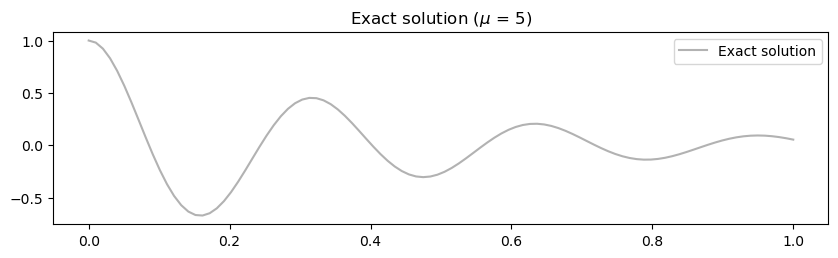

In [22]:
plt.figure(figsize=(10,2.5))
plt.plot(test_in_t_mu[0], 
         u_exact.cpu(), 
         label="Exact solution", 
         color="tab:grey", 
         alpha=0.6)
plt.title(f"Exact solution ($\mu$ = {test_mu})")
plt.legend()
plt.show()

### Step 2: Create Model Class (NN)

In [23]:
### Definition of the Fully Connected Neural Network Class:
# define NN
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [24]:
### Definition of the Fully Connected Neural Network Class
### ADDED ACTIVATION FUNCTION and INITIALIZATION

class FCN_init(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, activation = "Tanh"):#, initialization = "Xavier"):
        super().__init__()
        activation_functions = nn.ModuleDict([
            ["Tanh", nn.Tanh()],
            ["ReLU", nn.ReLU()],
            ["LeakyReLU", nn.LeakyReLU()],
            ["Sigmoid", nn.Sigmoid()],
            ["Softmax", nn.Softmax()],
            ])
      # initialization_type = nn.ModuleDict([
      #     ["Xavier", nn.init.xavier_normal_],
      #     ])
        #activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation_functions[activation]])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation_functions[activation]]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.weights_and_bias_initialization()
        #self.initialization = initialization
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

    def weights_and_bias_initialization(self):
        for module_with_layers in self.modules():
            if isinstance(module_with_layers, nn.Linear):
                #initialization_type(module_with_layers.weight)
                nn.init.xavier_uniform_(module_with_layers.weight)
                #nn.init.constant_(module_with_layers.bias, 0)
        

### STEP 3: Instantiate the Model Class

In [25]:
model_init = FCN_init(2,1,64,4, activation= "Tanh")
#model_init.parameters

In [26]:
model_init.state_dict()

OrderedDict([('fcs.0.weight',
              tensor([[-0.0216, -0.1466],
                      [-0.1395,  0.0435],
                      [ 0.0987,  0.0206],
                      [ 0.2535,  0.1487],
                      [-0.0186,  0.2706],
                      [ 0.2128, -0.0282],
                      [-0.0888, -0.1120],
                      [-0.0930, -0.0410],
                      [ 0.0445,  0.2546],
                      [-0.1706, -0.2536],
                      [-0.3003, -0.1721],
                      [-0.0197, -0.1659],
                      [-0.2705,  0.1050],
                      [-0.0687, -0.2370],
                      [-0.2436, -0.0726],
                      [ 0.1456, -0.2699],
                      [ 0.0870,  0.0186],
                      [-0.0924, -0.0702],
                      [-0.2049,  0.0565],
                      [ 0.2734,  0.0723],
                      [-0.2824,  0.1230],
                      [-0.0173,  0.0720],
                      [ 0.0021,  0.0657],
    

In [27]:
#model_init.state_dict()["fce.weight"]

In [28]:
#plt.imshow(model_init.state_dict()["fcs.0.weight"])

In [29]:
prueba = model_init.state_dict()["fce.weight"]
prueba == model_init.state_dict()["fce.weight"]

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True]])

### STEP 4: Selection of the Optimizer

In [30]:
optimizer = torch.optim.Adam(model_init.parameters(), lr= learning_rate)
#optimizer

#### Test points:

In [31]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
test_in_t_constant_mu.size()

torch.Size([100, 2])

In [32]:
#test_domain_t_constant_mu = torch.stack(torch.meshgrid(*test_in_t_constant_mu, indexing='ij'), -1).view(-1, 2)
#test_domain_t_constant_mu.size()

In [33]:
#test_domain_t_constant_mu

In [34]:
test_predicted = model_init(test_in_t_constant_mu)
test_predicted.size()

torch.Size([100, 1])

In [35]:
#test_predicted

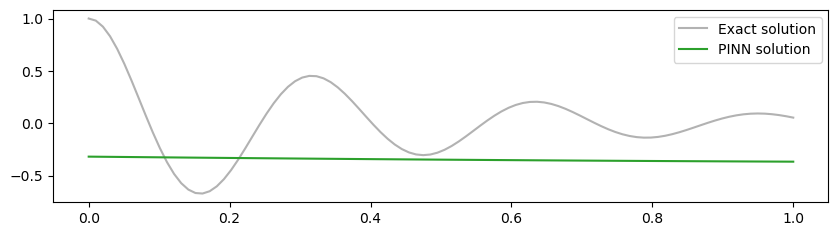

In [36]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))
#plt.scatter(physics_t_frict_coeff.detach().cpu()[0:physics_t_points, 0], 
#                    torch.zeros_like(physics_t_frict_coeff.cpu())[0:physics_t_points, 0], 
#                    s=20, 
#                    linewidth=0, 
#                    color="tab:green", 
#                    alpha=0.6)
#plt.scatter(initial_t_frict_coeff.detach().cpu()[:, 0], 
#                    torch.zeros_like(initial_t_frict_coeff.cpu())[:, 0], 
#                    s=100, 
#                    linewidth=0, 
#                    color="tab:red", 
#                    alpha=0.6)
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution", 
                 color="tab:green")
#plt.title(f"Training step {i}")
plt.legend()
plt.show()

## For-loop training

In [37]:
epochs = 1001

### Training using a different initialization: 

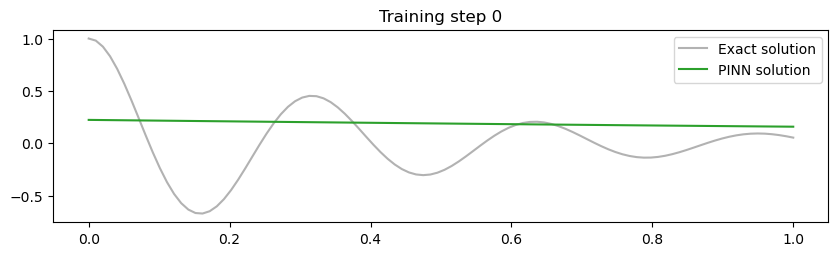

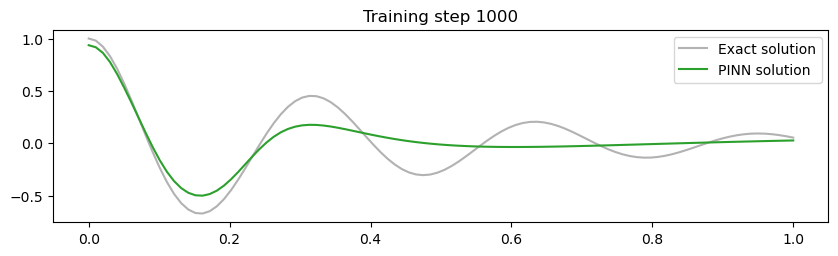

In [38]:
for i in range(epochs):
    optimizer.zero_grad()

    # compute initial condition 1 loss:
    ic1_predicted= model_init(ic1_t_mu)
    loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)

    # compute initial condition 2 loss:
    du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
    ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
    loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)

    
    # compute physic loss:
    physic_domain_predicted = model_init(physic_domain_t_mu)
    physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
    physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
    loss_differential_equation_1 = torch.mean( (physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + k * physic_domain_predicted )**2)

    loss_1 = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation_1

    
    loss_1.backward()
    optimizer.step()
    
    
    if i%1000 == 0:
        test_predicted = model_init(test_in_t_constant_mu)
        
        plt.figure(figsize=(10,2.5))
#plt.scatter(physics_t_frict_coeff.detach().cpu()[0:physics_t_points, 0], 
#                    torch.zeros_like(physics_t_frict_coeff.cpu())[0:physics_t_points, 0], 
#                    s=20, 
#                    linewidth=0, 
#                    color="tab:green", 
#                    alpha=0.6)
#plt.scatter(initial_t_frict_coeff.detach().cpu()[:, 0], 
#                    torch.zeros_like(initial_t_frict_coeff.cpu())[:, 0], 
#                    s=100, 
#                    linewidth=0, 
#                    color="tab:red", 
#                    alpha=0.6)
        plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
        plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution", 
                 color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        

### Inference:

In [39]:
test_mu = 7
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
test_in_t_constant_mu.size()

torch.Size([100, 2])

In [40]:
test_predicted = model_init(test_in_t_constant_mu)

In [41]:
u_exact = exact_solution(test_mu/(2*mass), w0, test_in_t_mu[0])

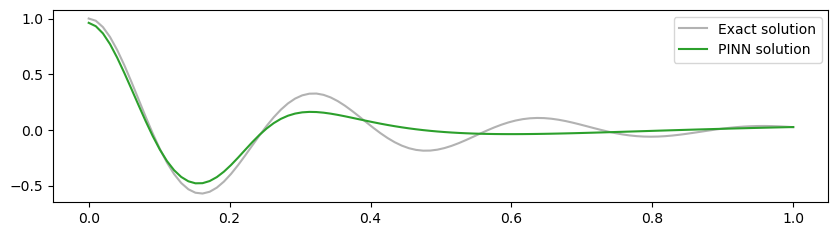

In [42]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))
#plt.scatter(physics_t_frict_coeff.detach().cpu()[0:physics_t_points, 0], 
#                    torch.zeros_like(physics_t_frict_coeff.cpu())[0:physics_t_points, 0], 
#                    s=20, 
#                    linewidth=0, 
#                    color="tab:green", 
#                    alpha=0.6)
#plt.scatter(initial_t_frict_coeff.detach().cpu()[:, 0], 
#                    torch.zeros_like(initial_t_frict_coeff.cpu())[:, 0], 
#                    s=100, 
#                    linewidth=0, 
#                    color="tab:red", 
#                    alpha=0.6)
plt.plot(test_in_t_mu[0].detach().numpy(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_in_t_mu[0], 
                 test_predicted[:,0].detach().numpy(), 
                 label="PINN solution", 
                 color="tab:green")
#plt.title(f"Training step {i}")
plt.legend()
plt.show()